In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta

from scipy import stats
import scikit_posthocs as sp
import pylab 

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


from tqdm.auto import tqdm

%matplotlib inline

# Описание эксперимента и задачи

Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для **новых пользователей** из нескольких стран была **изменена стоимость премиум-подписки** (деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит) при покупке через две новые платежные системы. При этом **стоимость пробного периода оставалась прежней**.

Проверьте:

- Был ли эксперимент успешен в целом.
- Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.


# Загрузка данных

- uid – идентификатор пользователя
- age – возраст
- attraction_coeff – коэффициент привлекательности (от 0 до 1000, (лайки/просмотры) *1000) 
- coins – число монеток (внутренняя валюта)
- country – страна  
- visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
- gender – пол
- age_filter_start  – фильтр поиска, мин. значение 
- age_filter_end  – фильтр поиска, макс. значение 
- views_count – число полученных оценок 
- was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)
- is_premium –  является ли премиум
- total_revenue – нормированная выручка

In [2]:
users_test_path = 'Проект_3_users_test.csv'
users_test = pd.read_csv(users_test_path, sep=';')
users_test['cr'] = users_test.total_revenue.apply(lambda x: 1 if x > 0 else 0)
users_test['group'] = 'Test'
# unique uid - 4308

users_control_1_path = 'Проект_3_users_control_1.csv'
users_control_1 = pd.read_csv(users_control_1_path, sep=';')
users_control_1['cr'] = users_control_1.total_revenue.apply(lambda x: 1 if x > 0 else 0)
users_control_1['group'] = 'Control1'
# unique uid - 4340

users_control_2_path = 'Проект_3_users_control_2.csv'
users_control_2 = pd.read_csv(users_control_2_path, sep=';')
users_control_2['cr'] = users_control_2.total_revenue.apply(lambda x: 1 if x > 0 else 0)
users_control_2['group'] = 'Control2'
# unique uid - 4264

- uid – идентификатор пользователя
- country – страна
- joined_at – дата и время регистрации
- paid_at – дата и время покупки
- revenue – нормированная выручка
- payment_id – идентификатор платежа
- from_page – откуда пользователь перешел на страницу оплаты
- product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое)

In [3]:
transactions_test_path = 'Проект_3_transactions_test.csv'
transactions_test = pd.read_csv(transactions_test_path, sep=';', parse_dates=['joined_at', 'paid_at'])
transactions_test['diff_dates'] = (transactions_test.paid_at - transactions_test.joined_at).dt.days
transactions_test['paid_day'] = transactions_test.paid_at.dt.day
transactions_test['paid_month'] = transactions_test.paid_at.dt.month
transactions_test['paid_year'] = transactions_test.paid_at.dt.year
transactions_test['joined_day'] = transactions_test.joined_at.dt.day
transactions_test['joined_month'] = transactions_test.joined_at.dt.month
transactions_test['joined_year'] = transactions_test.joined_at.dt.year
transactions_test['group'] = 'Test'
# unique uid - 146

transactions_control_1_path = 'Проект_3_transactions_control_1.csv'
transactions_control_1 = pd.read_csv(transactions_control_1_path, sep=';', parse_dates=['joined_at', 'paid_at'])
transactions_control_1['diff_dates'] = (transactions_control_1.paid_at - transactions_control_1.joined_at).dt.days
transactions_control_1['paid_day'] = transactions_control_1.paid_at.dt.day
transactions_control_1['paid_month'] = transactions_control_1.paid_at.dt.month
transactions_control_1['paid_year'] = transactions_control_1.paid_at.dt.year
transactions_control_1['joined_day'] = transactions_control_1.joined_at.dt.day
transactions_control_1['joined_month'] = transactions_control_1.joined_at.dt.month
transactions_control_1['joined_year'] = transactions_control_1.joined_at.dt.year
transactions_control_1['group'] = 'Control1'
# unique uid - 193

transactions_control_2_path = 'Проект_3_transactions_control_2.csv'
transactions_control_2 = pd.read_csv(transactions_control_2_path, sep=';', parse_dates=['joined_at', 'paid_at'])
transactions_control_2['diff_dates'] = (transactions_control_2.paid_at - transactions_control_2.joined_at).dt.days
transactions_control_2['paid_day'] = transactions_control_2.paid_at.dt.day
transactions_control_2['paid_month'] = transactions_control_2.paid_at.dt.month
transactions_control_2['paid_year'] = transactions_control_2.paid_at.dt.year
transactions_control_2['joined_day'] = transactions_control_2.joined_at.dt.day
transactions_control_2['joined_month'] = transactions_control_2.joined_at.dt.month
transactions_control_2['joined_year'] = transactions_control_2.joined_at.dt.year
transactions_control_2['group'] = 'Control2'
# unique uid - 187

# Предобработка данных

Для начала проверим, что пользователи в группах не пересекаются:

In [4]:
list_test = users_test.uid.tolist()
list_control_1 = users_control_1.uid.tolist()

[users_control_2.query("uid in @list_test").shape[0], 
 users_control_2.query("uid in @list_control_1").shape[0]]

[0, 0]

Проверим данные транзакций, видим, что в первой контрольной группе есть пропущенные данные для всех столбцов:

In [5]:
pd.DataFrame.from_dict({'control_1': transactions_control_1.isna().sum(), 
                        'control_2': transactions_control_2.isna().sum(),
                        'test': transactions_test.isna().sum()}, orient='index')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,diff_dates,paid_day,paid_month,paid_year,joined_day,joined_month,joined_year,group
control_1,630,630,630,630,630,630,630,630,630,630,630,630,630,630,630,0
control_2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
test,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


В реальном кейсе нужно было бы проверить, действительно ли это просто пропущенные значения, которые означают отсутствие транзакций. А нашем случае создадим для первой контрольной группы новый очищенный от пропущенных данных датасет.

Далее проверим длительность эксперимента. Для начала определим начало эксперимента как наименьшую дату регистрации по всем трем группам:

In [6]:
transactions_control_1_nnan = transactions_control_1.loc[~transactions_control_1.uid.isna()]

min(transactions_control_1_nnan.joined_at.min(), 
    transactions_control_2.joined_at.min(),
    transactions_test.joined_at.min())

Timestamp('2015-01-19 11:49:00')

Получаем данные за 2015 год при общих данных за 2017, попробуем разобраться с этим. Действительно, есть 1 такой пользователь из первой контрольной группы, который, видимо, случайно попал в группу новых пользователей:

In [7]:
pd.DataFrame.from_dict({
    'control_1': transactions_control_1_nnan.loc[transactions_control_1_nnan.joined_year != 2017].shape[0], 
    'control_2': transactions_control_2.loc[transactions_control_2.joined_year != 2017].shape[0],
    'test': transactions_test.loc[transactions_test.joined_year != 2017].shape[0]},
    orient='index')

,0
control_1,3
control_2,0
test,0


In [8]:
transactions_control_1_nnan.loc[transactions_control_1_nnan.joined_year != 2017]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,diff_dates,paid_day,paid_month,paid_year,joined_day,joined_month,joined_year,group
65,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0.0,refund_VP,other_type,695.0,14.0,12.0,2016.0,19.0,1.0,2015.0,Control1
101,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0.0,refung_AP,other_type,695.0,14.0,12.0,2016.0,19.0,1.0,2015.0,Control1
224,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0.0,refund_WP,other_type,695.0,14.0,12.0,2016.0,19.0,1.0,2015.0,Control1


Так как это явно не новый пользователь, для которых и проводился эксперимент, исключим его и определим реальное начало эксперимента:

In [9]:
transactions_control_1_nnan0 = transactions_control_1_nnan.loc[transactions_control_1_nnan.joined_year != 2015]

MIN_EXP_DATE = min(transactions_test.joined_at.min(), 
                   transactions_control_1_nnan0.joined_at.min(), 
                   transactions_control_2.joined_at.min())
MIN_EXP_DATE

Timestamp('2017-01-11 01:06:00')

Теперь определим конец эксперимента как самую последнюю дату оплаты по всем трем группам. Видим, что эксперимент длился около 11 месяцев, что, как мне кажется, достаточно долго. Однако, возможно, это молодой продукт и чтобы без потерь набрать аудиторию для эксперимента понадобилось столько времени:

In [10]:
MAX_EXP_DATE = max(transactions_test.paid_at.max(), 
                    transactions_control_1_nnan0.paid_at.max(), 
                    transactions_control_2.paid_at.max())
MAX_EXP_DATE

Timestamp('2017-12-11 23:28:00')

In [12]:
MAX_EXP_DATE - MIN_EXP_DATE

Timedelta('334 days 22:22:00')

Также можно заметить, что во всех трех экспериментальных есть пользователи, у которых дата оплаты раньше, чем дата регистрации. Можно предположить, что это:
- ошибки в сборе данных (одна из - неверно получены даты регистрации пользователей)
- пользователи, которые были раньше зарегистрированы, затем удалили аккаунт и потом снова зарегистрировались и для этих пользователей подтянулись их исторические данные

In [14]:
transactions_test.loc[transactions_test.diff_dates < 0].head(2)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,diff_dates,paid_day,paid_month,paid_year,joined_day,joined_month,joined_year,group
11,891861048,Canada,2017-10-26 02:55:00,2017-10-11 19:00:00,3588,68,none,premium_no_trial,-15,11,10,2017,26,10,2017,Test
20,891806280,United States of America,2017-10-27 08:56:00,2017-03-11 10:57:00,8242,147,trial_vip_popup,trial_premium,-230,11,3,2017,27,10,2017,Test


Соответственно, для таких записей разница дат регистрации и оплаты будет отрицательной. Посмотрим, сколько таких записей в каждой из групп:

In [15]:
pd.DataFrame.from_dict(
    {'control_1': transactions_control_1_nnan0.loc[transactions_control_1_nnan0.diff_dates < 0].shape[0], 
     'control_2': transactions_control_2.loc[transactions_control_2.diff_dates < 0].shape[0],
     'test': transactions_test.loc[transactions_test.diff_dates < 0].shape[0]},
    orient='index')

,0
control_1,55
control_2,60
test,47


Посмотрим на некоторые распределения для, предположительно, некорректных записей (diff_dates < 0) и корректных (diff_dates >= 0):
- Распредление дней, в которые происходили оплаты 
- Распредление месяцев, в которые регистрировались новые пользователи

Для большей наглядности в последующем анализе обернем отрисовку графиков всех трех групп в функцию (функция без аргументов, создана только для удобства, поэтому не будет описана):

In [16]:
def pay_days_dist():
    figure, axis = plt.subplots(2, 3, figsize=(20, 7))
    
    
    axis[0, 0].hist(transactions_control_1_nnan0.loc[transactions_control_1_nnan0.diff_dates >= 0].paid_day, 
                    color = 'lightgrey')
    axis[0, 0].hist(transactions_control_1_nnan0.loc[transactions_control_1_nnan0.diff_dates < 0].paid_day, 
                    color = 'red')
    axis[0, 0].set_title("Control1 (payment days)")
    axis[1, 0].hist(transactions_control_1_nnan0.loc[transactions_control_1_nnan0.diff_dates >= 0].joined_month,
                   color = 'lightgrey')
    axis[1, 0].hist(transactions_control_1_nnan0.loc[transactions_control_1_nnan0.diff_dates < 0].joined_month, 
                    color = 'red')
    axis[1, 0].set_title("Control1 (registration months)")

    
    axis[0, 1].hist(transactions_control_2.loc[transactions_control_2.diff_dates >= 0].paid_day, 
                    color = 'lightgrey')
    axis[0, 1].hist(transactions_control_2.loc[transactions_control_2.diff_dates < 0].paid_day, 
                    color = 'red')
    axis[0, 1].set_title("Control2 (payment days)")
    axis[1, 1].hist(transactions_control_2.loc[transactions_control_2.diff_dates >= 0].joined_month,
                   color = 'lightgrey')
    axis[1, 1].hist(transactions_control_2.loc[transactions_control_2.diff_dates < 0].joined_month, 
                    color = 'red')
    axis[1, 1].set_title("Control2 (registration months)")
    
    
    axis[0, 2].hist(transactions_test.loc[transactions_test.diff_dates >= 0].paid_day, 
                    color = 'lightgrey', label = 'diff >= 0')
    axis[0, 2].hist(transactions_test.loc[transactions_test.diff_dates < 0].paid_day, 
                    color = 'red', label = 'diff < 0')
    axis[0, 2].set_title("Test (payment days)")
    axis[1, 2].hist(transactions_test.loc[transactions_test.diff_dates >= 0].joined_month,
                   color = 'lightgrey')
    axis[1, 2].hist(transactions_test.loc[transactions_test.diff_dates < 0].joined_month, 
                    color = 'red')
    axis[1, 2].set_title("Test (registration months)")
    
    
    figure.legend(loc='upper right')

Видим:
- около 40% всех оплат происходили 11-ого числа 
- все оплаты для некорретных записей происходили только 11-ого числа 
- все оплаты и регистрации произошли в числа начиная с 11, т.е. нет оплат и регистраций в числа 1, 2, 3, ..., 10 (из списков под графиками)
- все пользователи пользователи с некорретными записями были зарегистрированы только в октябре

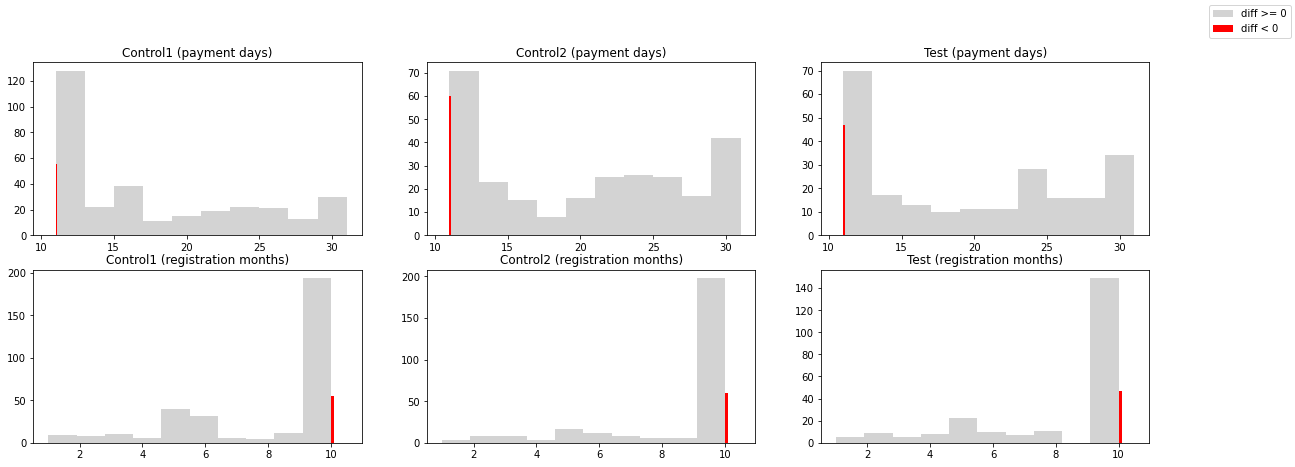

In [17]:
pay_days_dist()

In [18]:
[transactions_control_1_nnan0.loc[transactions_control_1_nnan0.joined_day < 11].shape[0],
 transactions_control_2.loc[transactions_control_2.joined_day < 11].shape[0],
 transactions_test.loc[transactions_test.joined_day < 11].shape[0]]

[0, 0, 0]

In [19]:
[transactions_control_1_nnan0.loc[transactions_control_1_nnan0.paid_day < 11].shape[0],
 transactions_control_2.loc[transactions_control_2.paid_day < 11].shape[0],
 transactions_test.loc[transactions_test.paid_day < 11].shape[0]]

[0, 0, 0]

Вспомним 2 изначальных предположения о причинах некорректных данных:
- Ошибки в сборе данных (одна из - неверно получены даты регистрации пользователей)
- Есть пользователи, которые были раньше зарегистрированы, затем удалили аккаунт и затем снова зарегистрировались. Для этих пользователей подтянулись их исторические данные

В каком-то реальном кейсе нужно было бы посмотреть/узнать действительно ли распределение на группы у нас абсолютно случайно, а также правильно ли собираются данные, например, вот эти моменты:
- около 40% всех оплат происходили 11-ого числа 
- все оплаты для некорретных записей происходили только 11-ого числа 
- все оплаты и регистрации произошли в числа начиная с 11, т.е. нет оплат и регистраций в числа 1, 2, 3, ..., 10 (из списков под графиками)
- все пользователи пользователи с некорретными записями были зарегистрированы только в октябре

Вероятность того, что мы случайно получили такие данные и что это действительно наши старые пользователи, все же сохраняется. Однако в данном случае совокупность всех выявленных неточностей и попадание одного явно не нового пользователя в одну из групп, склоняет к тому, что это все же ошибка в сборе данных. 

Как минимум наличие дат оплат более ранних, чем регистрация, и то, что для всех этих записей дата регистрации указана в октябре, можно объяснить какой-то ошибкой в сборе данных, в результате чего некоторым пользователям проставился 10-ый месяц в дату регистрации вместо истинного. 

Таким образом, в данной ситуации, когда нельзя получить ответ на счет достоверности данных, а также на основании того, что сумма по транзакциям и общая сумма из users-датасетов совпадают и нет дат оплат меньших минимальной даты регистрации, будем считать, что все эти пользователи - новые (в нашем случае дата регистрации не повлияет на изменение исследуемых метрик).

# Анализ результатов эксперимента

Я считаю, в реальном проекте стоило бы проверить датасет первого контроля на предмет того, можем ли мы доверять данным из него, т.к. на этапе предобработки данных мы выяснили:
- в датасет попал 1 не новый пользователь
- в датасете есть немалое количество пропущенных значений и стоило бы узнать, действительно ли это означает отсутствие транзакций 

Таким образом, т.к. проверить достоверность данных мы не можем, будем исходить из того, что мы можем доверять этим данным, однако не забываем про одного не нового пользователя и для последующего анализа будем использовать новый датасет, который исключает его:

In [20]:
users_control_1_cln = users_control_1[users_control_1.uid != 960936960]

Проверим действительно ли трафик разделен поровну между всеми группами. Для этого используем *критерий хи-квадрат* со следующими гипотезами:
- *H0:* Категориальные данные имеют заданные частоты
- *H1:* Категориальные данные не имеют заданные частоты

По результатам теста у нас нет оснований отклонить нулевую гипотезу, трафик разделен поровну:

In [21]:
observed = [users_test.shape[0], users_control_1_cln.shape[0], users_control_2.shape[0]]
total_traffic= sum(observed)
expected = [total_traffic/3, total_traffic/3,  total_traffic/3]

chi = stats.chisquare(observed, f_exp=expected)
print(chi)

Power_divergenceResult(statistic=0.6600573154674308, pvalue=0.7189031310022227)


##   *Дизайн эксперимента*

Попробуем восстановить изначальный дизайн эксперимента по имеющейся информации. Целью сплит-теста является проверить влияние на продукт изменения ценовой политики. На мой взгляд, в этом случае стоит посмотреть в первую очередь на изменение конверсии (*CR*), не "спугнули" ли мы таким образом клиентов. Затем посмотрим на денежные метрики (средний чек или *AOV, ARPU, ARPPU*), при чем *ARPU* и *ARPU* связаны через конверсию *ARPU = CR * ARPPU*. 

Предполагаю, что цены были подняты, что, естественно, повлечет за собой увеличение метрик *AOV* и *ARPPU*, однако анализ конверсии и сравнения *ARPU* и *ARPU* помогут нам принять верное решение об успешности эксперимента.

##   *Конверсия*

### Подготовка и выбор критерия

Приступим к изучению конверсии. В реальных кейсах одна из основных задач - это определить размер выборки. В данном задании этот показатель уже известен, поэтому попробуем определить минимальный размер эффекта (*MDE*), который мы можем задетектировать. Так как при анализе конверсии нескольких групп используются две категориальные переменные
категориальные, для проверки гипотез будем использовать критерий *хи-квадрат* со следующими вводными:
- Метрика: CR (Конверсия) = число пользователей, совершивших покупку/общее число пользователей
- Статистический тест: хи-квадрат
    - *H0: Переменные группировки независимы относительно наблюдаемых частот*
    - *H1: Переменные группировки имеют завивимость относительно наблюдаемых частот*
- Допустимая вероятность ошибки I рода: 0.05 (стандартно)
- Мощность: 0.8 (стандартно)
- Начальный уровень: 0.0441
- MDE: в нашем случае неизвестен
- Размер выборки: 4304

У нас нет какого-то baseline-значения конверсии, поэтому будем считать, что реальное значение лежит где-то между значениями двух контрольных групп, а размер выборки возьмем как среднее выборок всех групп:

In [22]:
baseline = round(np.mean([transactions_control_1_nnan0.uid.nunique()/users_control_1_cln.shape[0],
                          transactions_control_2.uid.nunique()/users_control_2.shape[0]]), 4)
baseline

0.0441

In [23]:
sample_size = round(np.mean([users_control_1_cln.shape[0], users_control_2.shape[0], users_test.shape[0]]))
sample_size

4304

Теперь определим MDE с помощью симуляций *методом Монте-Карло*, в которых будем сравнивать сгенерированные биномиальные распределения (таким распределением характеризуется конверсия) с заданными параметрами и применять различный MDE для поиска такого, который обеспечивает выбранный уровень мощности:

  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'mde = 0.013, power = 0.78')

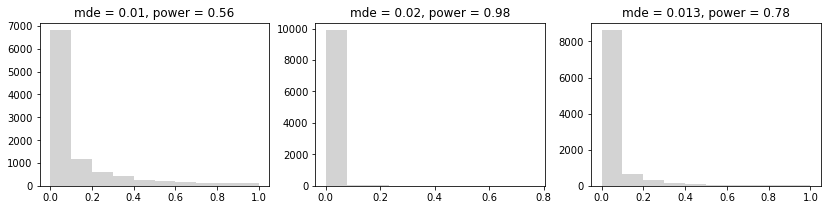

In [24]:
mde1 = 0.01
mde2 = 0.02
mde3 = 0.013

power_chk_list1 = []
power_chk_list2 = []
power_chk_list3 = []
for _ in tqdm(range(10000)):
    a = np.random.binomial(1, baseline, size=sample_size)
    b = np.random.binomial(1, baseline + mde1, size=sample_size)
    c = np.random.binomial(1, baseline + mde2, size=sample_size)
    d = np.random.binomial(1, baseline + mde3, size=sample_size)

    _, pvalue1, _, _ = stats.chi2_contingency([[a.sum(), b.sum()], 
                                        [len(a) - a.sum(), len(b) - b.sum()]])
    _, pvalue2, _, _ = stats.chi2_contingency([[a.sum(), c.sum()], 
                                        [len(a) - a.sum(), len(c) - c.sum()]])
    _, pvalue3, _, _ = stats.chi2_contingency([[a.sum(), d.sum()], 
                                        [len(a) - a.sum(), len(d) - d.sum()]])
    power_chk_list1.append(pvalue1)
    power_chk_list2.append(pvalue2)
    power_chk_list3.append(pvalue3)
    
figure, axis = plt.subplots(1, 3, figsize=(14, 3))

axis[0].hist(pd.Series(power_chk_list1), color = 'lightgrey')
axis[0].set_title("mde = {}, power = {}".format(mde1, round((pd.Series(power_chk_list1) < 0.05).mean(), 2)))
axis[1].hist(pd.Series(power_chk_list2), color = 'lightgrey')
axis[1].set_title("mde = {}, power = {}".format(mde2, round((pd.Series(power_chk_list2) < 0.05).mean(), 2)))
axis[2].hist(pd.Series(power_chk_list3), color = 'lightgrey')
axis[2].set_title("mde = {}, power = {}".format(mde3, round((pd.Series(power_chk_list3) < 0.05).mean(), 2)))

Видим: 
- при *MDE = 0.01* не обеспечивается желаемая мощность, т.е. для детектирования такого изменения необходима выборка большего размера
- при *MDE = 0.02* наблюдается переизбыток мощность, т.е. для детектирования такого изменения можем взять меньшую выборку или если есть возможность все-таки набрать такую выборку, то можем задетектировать еще меньший эффект
- вероятно, изначально предполагался *MDE = 0.013*, т.к. мощность практически совпадает с изначально установленной - *0.8*


Также сторонний калькулятор https://www.evanmiller.org/ab-testing/sample-size.html дает похожие результаты:
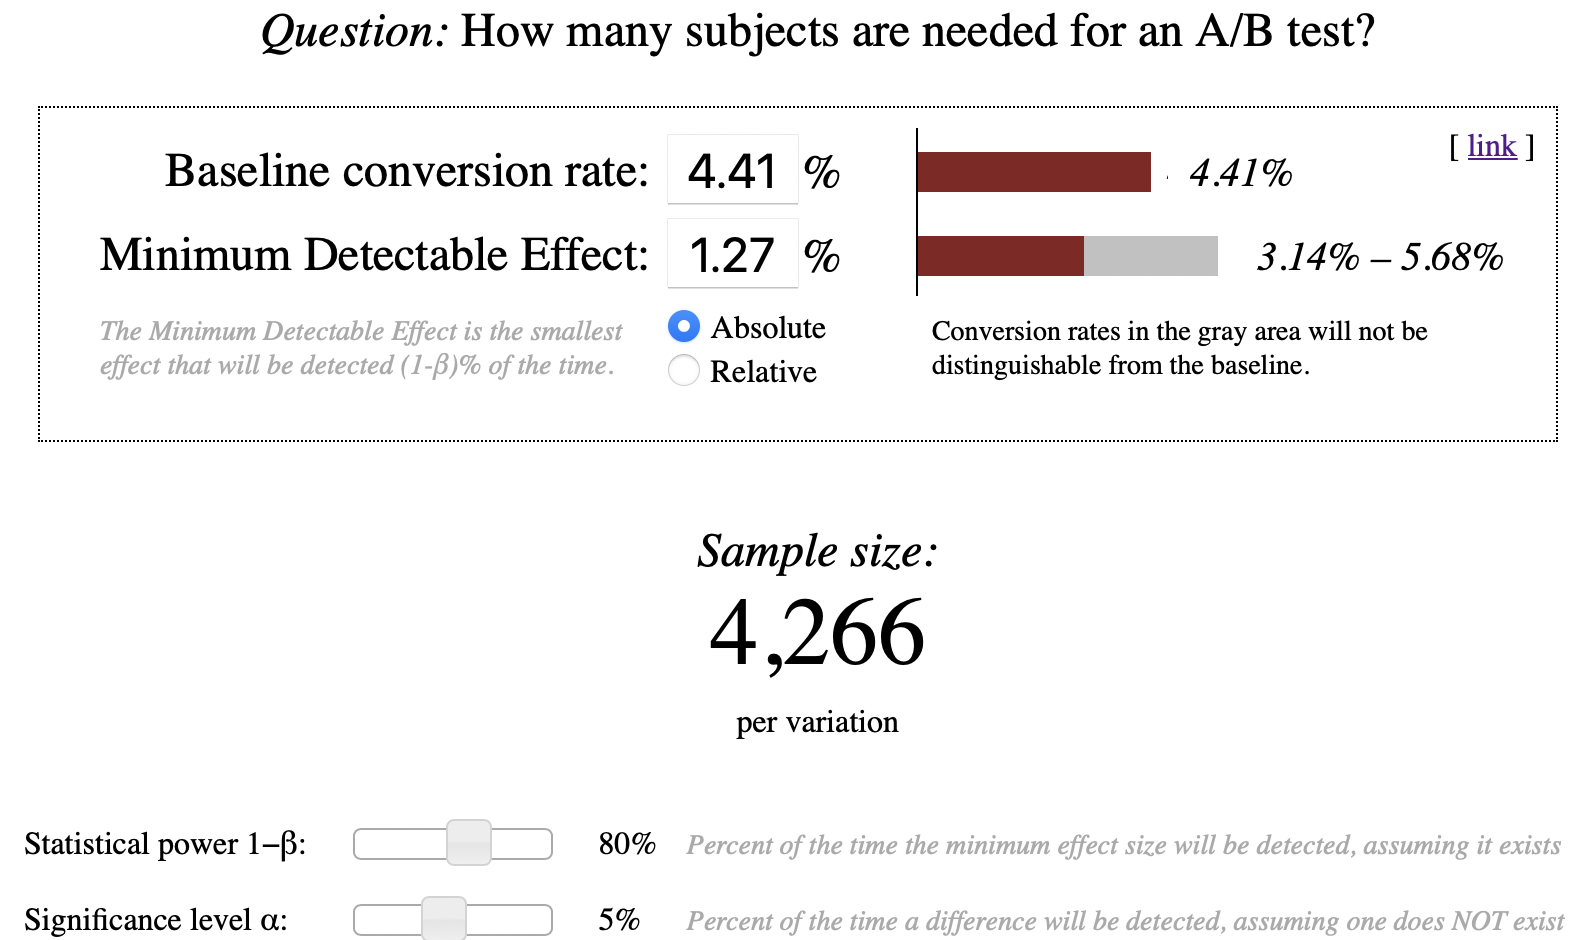

Далее проверим, обеспечивается ли заданная допустимая ошибка I рода - *0.05*. Видим, что выбранный критерий в целом обеспечивает и этот пункт, однако с некоторым занижением чувствительности:

  0%|          | 0/10000 [00:00<?, ?it/s]

0.0435

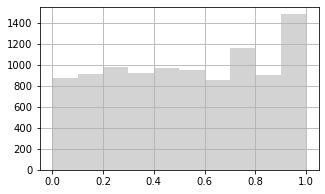

In [25]:
alpha_chk_list = []
for _ in tqdm(range(10000)):
    a = np.random.binomial(1, baseline, size=sample_size)
    b = np.random.binomial(1, baseline, size=sample_size)

    _, pvalue, _, _ = stats.chi2_contingency([[a.sum(), b.sum()], 
                                        [len(a) - a.sum(), len(b) - b.sum()]])
    alpha_chk_list.append(pvalue)

plt.figure(figsize=(5, 3))
pd.Series(alpha_chk_list).hist(color = 'lightgrey')
(pd.Series(alpha_chk_list) < 0.05).mean()

### Сравнение экспериментальных групп 

Перейдем к оценке результатов эксперимента. Для начала проверим, есть ли разница между всеми тремя группами. По результатам теста можем отклонить нулевую гипотезу о независимости экспериментальных групп:

In [26]:
_, pvalue_3g, _, _ = stats.chi2_contingency([[users_control_1_cln.cr.sum(), 
                                              users_control_2.cr.sum(),
                                              users_test.cr.sum()], 
                                            [len(users_control_1_cln.cr) - users_control_1_cln.cr.sum(), 
                                             len(users_control_2.cr) - users_control_2.cr.sum(),
                                             len(users_test.cr) - users_test.cr.sum()]])
pvalue_3g

0.02418479124497552

Далее необходимо определить, между какими именно группами наблюдается значимое различие. Гипотезы остаются теми же, однако т.к. сравнений будет несколько, необходимо сделать поправку на это, применим *поправку Бонферрони*:

In [27]:
alpha, n = 0.05, 3
p_corr = alpha/n
p_corr

0.016666666666666666

Теперь проведем серию сравнений и результаты будем оценивать на основе скорректированного уровня значимости - *0.0167*. Для удобства сведем результаты в таблицу, а также посмотрим на график, который покажет характер различий в группах, если они имеются:

In [29]:
_, pvalueA_A, _, _ = stats.chi2_contingency([[users_control_1_cln.cr.sum(), 
                                           users_control_2.cr.sum()], 
                                        [len(users_control_1_cln.cr) - users_control_1_cln.cr.sum(), 
                                         len(users_control_2.cr) - users_control_2.cr.sum()]])

_, pvalueA1_B, _, _ = stats.chi2_contingency([[users_control_1_cln.cr.sum(), 
                                           users_test.cr.sum()], 
                                        [len(users_control_1_cln.cr) - users_control_1_cln.cr.sum(), 
                                         len(users_test.cr) - users_test.cr.sum()]])

_, pvalueA2_B, _, _ = stats.chi2_contingency([[users_control_2.cr.sum(), 
                                           users_test.cr.sum()], 
                                        [len(users_control_2.cr) - users_control_2.cr.sum(), 
                                         len(users_test.cr) - users_test.cr.sum()]])

chi_result = pd.DataFrame.from_dict({'Control1 vs Control2': pvalueA_A, 
                                     'Control1 vs Test': pvalueA1_B, 
                                     'Control2 vs Test': pvalueA2_B}, orient='index', columns=['pvalue'])
chi_result['p_corr'] = p_corr
chi_result['significant'] = chi_result.pvalue.apply(lambda x: 'yes' if x < p_corr else 'No')
chi_result

,pvalue,p_corr,significant
Control1 vs Control2,1.000000,0.016667,No
Control1 vs Test,0.017415,0.016667,No
Control2 vs Test,0.019731,0.016667,No


Text(0, 0.5, 'Conversion Rate Mean')

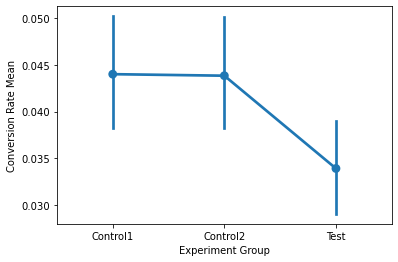

In [30]:
sns.pointplot(x="group", y="cr",
              data=pd.concat([users_control_1_cln[['cr', 'group']], 
                              users_control_2[['cr', 'group']], 
                              users_test[['cr', 'group']]]))
plt.xlabel("Experiment Group")
plt.ylabel("Conversion Rate Mean")

По результатам попарных сравнений значимые различия не обнаружены ни в одном из сравнений. Однако на основании отсутствия значимых отличий контрольных групп, отличий тестовой группы от обеих контрольных на уровне близком к значимому c поправкой и графика можно предположить, что поправка Бонферрони оказалась слишком консервативна в нашем случае.

**Моя оценка - конверсия в тестовой группе значимо снизилась по сравнению с обеими контрольными группами** (поправка Бонферрони слишком консервативна в данном случае).

Теперь можем количественно оценить изменение от нашего нововведения в целом по всему сервису, рассчитаем абсолюбное и относительное изменение в процентах:

In [31]:
[round((baseline - users_test.cr.sum()/users_test.shape[0]) * 100, 2), 
 round((baseline - users_test.cr.sum()/users_test.shape[0])/baseline * 100, 2)]

[1.02, 23.15]

### Сравнение экспериментальных групп в разрезах

Далее можем более подробно рассмотреть различия наших групп в некоторых разрезах, например, пол и возраст. Применять будем все тот же статистический критерий, однако теперь уже без сравнения двух контрольных групп между собой, т.к. это сравнение уже было проведено на общих данных и различия не найдены. 

Будем сравнивать тестовую группу с обеими контрольным (это и последующие сравнения конверсии будут производится с те ми же гипотезами что и раньше о независимости/зависимости наблюдаемых частот) и в этом случае нам все так же понадобится поправка Бонферрони на множественные сравнения, которая также рассчитана на этом шаге.

Для дальнейшего анализа произведем некоторые сведения данных для удобства и создадим функцию сравнения групп, которая принимает на вход число сконвертированных пользователей в необходимых срезах, а на выходе получаем датафрейм с полученным уровнем значимости, уровнем принятия решения (скорректированный поправкой), относительным изменением конверсии и решением о значимости результата.

In [32]:
users_merged = pd.concat([users_control_1_cln, users_control_2, users_test])

transactions_merged = pd.concat([transactions_control_1_nnan0, 
                                 transactions_control_2,
                                 transactions_test])

merged_all = transactions_merged.merge(users_merged, how='inner', on=['uid', 'group'])

p_corr1 = 0.05/2


'''
input: (integer) - number of converted users by experiment groups, precisely in the next order 
                   control group 1, control group 2, test group
output: (DataFrame) - result DataFrame which gives significance level, corrected significance level,
                      related change from baseline (one of the control group), decision on significance
'''
def get_chi_result(a1, a2, b):
    
    _, pvalueA1_B, _, _ = stats.chi2_contingency([[a1, b], 
                                                  [len(users_control_1_cln.cr) - a1, 
                                                   len(users_test.cr) - b]])

    _, pvalueA2_B, _, _ = stats.chi2_contingency([[a2, b], 
                                                  [len(users_control_2.cr) - a2, 
                                                   len(users_test.cr) - b]])
    
    diff1 = round(100*(b/len(users_test.cr) - a1/len(users_control_1_cln.cr))/(a1/len(users_control_1_cln.cr)), 2)
    diff2 = round(100*(b/len(users_test.cr) - a2/len(users_control_2.cr))/(a2/len(users_control_2.cr)), 2)
    
    diffp1 = '{:+.2f}%'.format(diff1)
    diffp2 = '{:+.2f}%'.format(diff2)
    
    res = pd.DataFrame.from_dict({'Control1 vs Test': [pvalueA1_B, p_corr1, diffp1], 
                                   'Control2 vs Test': [pvalueA2_B, p_corr1, diffp2]}, 
                                    orient='index', columns=['pvalue', 'p_corr', 'percent_diff'])
    
    res['significant'] = res.pvalue.apply(lambda x: 'Yes' if x < p_corr1 else 'No')
    
    return res

#### Разрез (экспериментальная группа/тип продукта)

Начнем со сравнения групп по типу продукта и дабы не растягивать ноутбук каждым отдельным сравнением сравним сразу все типы продуктов и сведем результаты в единую таблицу:

In [33]:
res_dict = {}
for product in merged_all.product_type.unique().tolist():
    chi_result0 = get_chi_result(merged_all.loc[(merged_all.group == 'Control1') & 
                                            (merged_all.product_type == product)].uid.nunique(),
                             merged_all.loc[(merged_all.group == 'Control2') & 
                                            (merged_all.product_type == product)].uid.nunique(),
                             merged_all.loc[(merged_all.group == 'Test') & 
                                            (merged_all.product_type == product)].uid.nunique())
    res_dict[product] = chi_result0
    
pd.concat(res_dict, axis=0)

pvalue  p_corr percent_diff significant
trial_premium    Control1 vs Test  0.685927   0.025       -8.30%          No
                 Control2 vs Test  0.545280   0.025      +13.92%          No
coins            Control1 vs Test  0.281058   0.025      -19.42%          No
                 Control2 vs Test  0.128057   0.025      -25.41%          No
premium_no_trial Control1 vs Test  0.017178   0.025      -31.84%         Yes
                 Control2 vs Test  0.006749   0.025      -34.98%         Yes
other_type       Control1 vs Test  0.201334   0.025      -34.01%          No
                 Control2 vs Test  0.064976   0.025      -43.01%          No

Сравнения показывают значимые отличия только для премиум-подписки (при чем для обеих контрольных групп), что очевидно, так как изменение было только в этом продукте, однако стоило проверить, не повлияло ли это на другие продукты. **Можно с большой уверенностью сказать, что конверсия в покупку премиум-подписки упала в среднем на 33.41% .**

Далее посмотрим на некоторые разрезы уже только внутри пользователей с премиум-подпиской, немного подготовим данные для таких сравнений:

In [35]:
prem_all = pd.concat([transactions_control_1_nnan0\
                          .loc[transactions_control_1_nnan0.product_type == 'premium_no_trial'],
                      transactions_control_2.loc[transactions_control_2.product_type == 'premium_no_trial'],
                      transactions_test.loc[transactions_test.product_type == 'premium_no_trial']])

prem_merged = prem_all.merge(users_merged, how='inner', on=['uid', 'group'])

#### Разрез (премиум-подписка + экспериментальная группа/пол)

"А вот в Tinder число мужчин превышает число женщин с соотношением 9:1. В Bumble, который изначально ориентирован на пользователей женского пола, количество мужчин превышает количество женщин более чем на 80%." - цитата автора статьи https://habr.com/ru/company/vdsina/blog/490238/ . Таким образом, исходя из этого и каких-то моих представлений об этой сфере, можно предположить, что гендер номер 1 представляет мужчин, а гендер номер 0, соответственно, женщин.

In [36]:
prem_merged.gender.value_counts(normalize=True).mul(100)

1    98.269896
0     1.730104
Name: gender, dtype: float64

В данных для премиум-подписки практически нет пользователей с гендером 0 (только 5 во второй контрольной группе), анализ для этой группы проводить не будем, т.к. результат будет нерепрезентативным и, к тому же, функция *chi2_contingency* выдает ошибку при подаче ей нулевых значений. Поэтому посмотрим, изменилась ли конверсия для пользователей с гендером 1:  

In [37]:
prem_merged.loc[prem_merged.gender == 0].group

121    Control2
140    Control2
190    Control2
204    Control2
210    Control2
Name: group, dtype: object

In [38]:
chi_result1 = get_chi_result(prem_merged.loc[(prem_merged.group == 'Control1') & 
                                            (prem_merged.gender == 1)].uid.nunique(),
                             prem_merged.loc[(prem_merged.group == 'Control2') & 
                                            (prem_merged.gender == 1)].uid.nunique(),
                             prem_merged.loc[(prem_merged.group == 'Test') & 
                                            (prem_merged.gender == 1)].uid.nunique())

chi_result1

,pvalue,p_corr,percent_diff,significant
Control1 vs Test,0.017178,0.025,-31.84%,Yes
Control2 vs Test,0.018628,0.025,-31.63%,Yes


Сравнение показывает значимые отличия для обеих контрольных групп, это также очевидно, т.к. 95% пользователей с премиум-подпиской это пользователи с гендером 1.

#### Разрез (премиум-подписка + экспериментальная группа/возрастная группа)

Теперь посмотрим на пользователей в разрезе возрастных групп, для этого на основе квартилей распределения возраста (немного подкорректированных под общие представления о возрастных группах) заводим новую переменную:

In [39]:
prem_merged.age.describe()

count    289.000000
mean      31.543253
std       12.544049
min       16.000000
25%       24.000000
50%       28.000000
75%       36.000000
max       99.000000
Name: age, dtype: float64

In [40]:
prem_merged['age_group'] = pd.cut(prem_merged.age, [0, 17, 25, 30, 40, 150], 
                                labels=["less18", "18_25", "26_30", "31_40", "40+"], 
                                right=True)

prem_merged.age_group.value_counts(normalize=True).mul(100)

18_25     32.525952
31_40     25.951557
26_30     24.913495
40+       14.878893
less18     1.730104
Name: age_group, dtype: float64

In [42]:
res_dict2 = {}
for age in prem_merged.age_group.unique().tolist():
    chi_result2 = get_chi_result(prem_merged.loc[(prem_merged.group == 'Control1') & 
                                            (prem_merged.age_group == age)].uid.nunique(),
                                 prem_merged.loc[(prem_merged.group == 'Control2') & 
                                            (prem_merged.age_group == age)].uid.nunique(),
                                 prem_merged.loc[(prem_merged.group == 'Test') & 
                                            (prem_merged.age_group == age)].uid.nunique())
    res_dict2[age] = chi_result2
    
pd.concat(res_dict2, axis=0)

pvalue  p_corr percent_diff significant
18_25  Control1 vs Test  0.066752   0.025      -41.25%          No
       Control2 vs Test  0.197390   0.025      -32.95%          No
26_30  Control1 vs Test  0.005606   0.025      -67.77%         Yes
       Control2 vs Test  0.000151   0.025      -76.01%         Yes
31_40  Control1 vs Test  0.863267   0.025       +9.88%          No
       Control2 vs Test  1.000000   0.025       -1.02%          No
40+    Control1 vs Test  0.864783   0.025      -12.71%          No
       Control2 vs Test  1.000000   0.025       -1.02%          No
less18 Control1 vs Test  1.000000   0.025       +0.72%          No
       Control2 vs Test  1.000000   0.025       -1.02%          No

Сравнение показывает значимые отличия для обеих контрольных групп только у пользователей в восрасте от 26 до 30, что не так очевидно. Можно было бы предположить, что так можем быть, если бОльшая покупателей премиум-подписки это люди в возрасте 26-30, но как мы видели ранее, это не самая многочисленная возрастная группа. **Можно с большой уверенностью сказать, что конверсия в покупку премиум-подписки пользователями возрастной группы 26-30 лет упала в среднем на 71.89% .**

## *Денежные метрики*

### Подготовка к анализу

После оценки изменения конверсии переходим к более понятным и показательным метрикам для бизнеса, которые в сочетании с конверсией покажут реальный результат эксперимента:
- средний чек (*AOV*) = общая выручка за период/количество транзакций за период
- средний доход на пользователя (*ARPU*) = общая выручка за период/количество пользователей за период
- средний доход на платящего пользователя (*ARPPU*) = общая выручка за период/количество клиентов за период

Для дальнейшего удобства сведем все датасеты users- и transactions- датасеты в два общих:

In [43]:
users_merged = pd.concat([users_control_1_cln, users_control_2, users_test])

transactions_merged = pd.concat([transactions_control_1_nnan0, 
                                 transactions_control_2,
                                 transactions_test])

Для начала посмотрим на основные описательные статистики каждой из групп. Видим, что в первой контрольной группе (снова она :)) максимальное значение намного превышает аналогичные показатели в двух других группах:

In [44]:
pd.DataFrame.from_dict({'control1': users_control_1_cln.total_revenue.describe(), 
                        'control2': users_control_2.total_revenue.describe(),
                        'test': users_test.total_revenue.describe()})

,control1,control2,test
count,4339.000000,4264.000000,4308.000000
mean,594.893063,450.384146,534.080316
std,7988.838896,2859.242228,4371.682632
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,486330.000000,81796.000000,129870.000000


Посмотрим на значения общего дохода с клиента выше, например 100.000 (примерно среднее максимального значения двух других групп), видим, что такой клиент всего один:

In [45]:
users_control_1_cln.loc[users_control_1_cln.total_revenue > 100000]

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,cr,group
1427,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330,1,Control1


Если теперь взглянуть на те же показатели, но с исключением этого пользователя, то заметим, насколько это значение утягивает за собой среднее в большую сторону:

In [46]:
BEST_USER = users_control_1_cln.loc[users_control_1_cln.total_revenue > 100000, 'uid'].values[0]

pd.DataFrame.from_dict({'control1': users_control_1_cln.loc[users_control_1_cln.uid != BEST_USER]\
                                                        .total_revenue.describe(), 
                        'control2': users_control_2.total_revenue.describe(),
                        'test': users_test.total_revenue.describe()})

,control1,control2,test
count,4338.000000,4264.000000,4308.000000
mean,482.920931,450.384146,534.080316
std,3069.590506,2859.242228,4371.682632
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,64298.000000,81796.000000,129870.000000


Такое значение явно похоже на выброс и можно было бы предположить ошибку в данных, однако сумма по транзакциям совпадает с общей суммой из users-датасета. Стоило бы проверить, достоверность данных по этому пользователю:

In [47]:
transactions_control_1_nnan0.loc[transactions_control_1_nnan0.uid == BEST_USER].revenue.sum()\
== \
users_control_1.loc[users_control_1.uid == BEST_USER].total_revenue

1427    True
Name: total_revenue, dtype: bool

Если посмотреть на пару *boxplot-графиков* с этим пользователем и без него, видим, что это значение слишком велико по сравнению с большинством значений и явно превышает все допустимые интервалы. Плюс к этому, такое высокое значение будет искажать результаты сравнения экспериментальных групп. Однако исключение этого пользователя из анализа рискованно, т.к. это деньги, которые клиент принес бизнесу, и это может быть не выбросом, а вполне закономерной историей для состоятельных пользователей нашего сервиса.  **В связи с описанным выше мной принято решение - все же не удалять это значение из анализа.**

Text(0.5, 1.0, 'Without outlier')

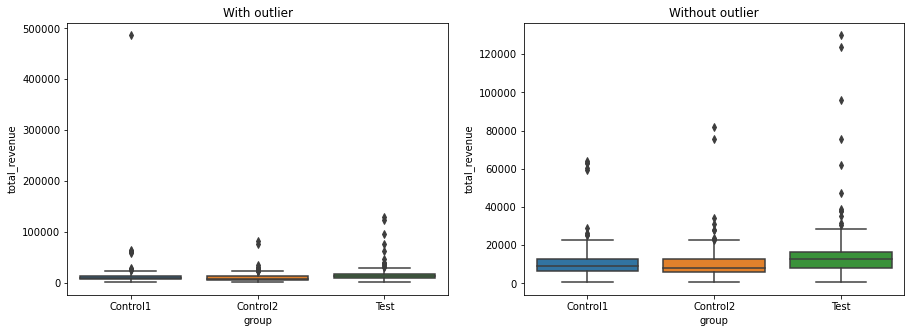

In [48]:
figure, axis = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=users_merged.loc[users_merged.cr == 1], x="group", y="total_revenue", ax=axis[0])
axis[0].set_title("With outlier")

sns.boxplot(data=users_merged.loc[(users_merged.cr == 1) & (users_merged.uid != BEST_USER)], 
            ax=axis[1], x="group", y="total_revenue")
axis[1].set_title("Without outlier")

### Выбор критерия и сравнение экспериментальных групп

Обернем создание трех графиков распределения и отрисовку QQ-графика (для проверки на нормальность) для наших трех групп в функцию, т.к. далее часто придется обращаться к этим представлениям и дальнейшее повествование будет выглядеть более аккуратно:

In [49]:
'''
input: (Series) - pandas Series of revenue by experiment groups, precisely in the next order 
                  control group 1, control group 2, test group
output: (3 histplots) - distributions of 3 inputed groups
'''
def get3distributions(a1, a2, b):
    figure, axis = plt.subplots(1, 3, figsize=(14, 3))
    axis[0].hist(a1, color = 'lightgrey')
    axis[0].set_title("Control1")
    axis[1].hist(a2, color = 'lightgrey')
    axis[1].set_title("Control2")
    axis[2].hist(b, color = 'lightgrey')
    axis[2].set_title("Test")
    
    
'''
input: (Series) - pandas Series of revenue by experiment groups, precisely in the next order 
                  control group 1, control group 2, test group
output: (3 probplots) - probability plots for normal distribution of 3 inputed groups
'''
def get3probs(a1, a2, b):
    figure, axis = plt.subplots(1, 3, figsize=(14, 3))
    stats.probplot(a1, dist="norm", plot=axis[0])
    axis[0].set_title("Control1")
    stats.probplot(a2, dist="norm", plot=axis[1])
    axis[1].set_title("Control2")
    stats.probplot(b, dist="norm", plot=axis[2])
    axis[2].set_title("Test")

Посмотрим на распределение среднего чека в группах, они, очевидно, даже визуально отличаются от нормального, однако проверим их QQ-графиком, по которому также видно, что распределения далеки от нормальных:

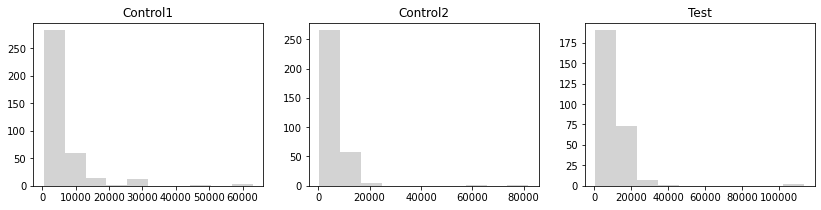

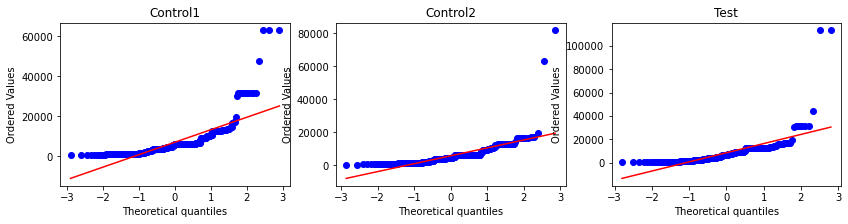

In [50]:
get3distributions(transactions_control_1_nnan0.revenue, 
                  transactions_control_2.revenue, 
                  transactions_test.revenue)

get3probs(transactions_control_1_nnan0.revenue, 
          transactions_control_2.revenue, 
          transactions_test.revenue)

Посмотрим на логарифм распределения среднего чека в группах, возможно, они являются логнормальным распределением (в этом случае мы бы могли такими же симуляциями, как для конверсии, воссоздать распределение средних из логнормального распределения с заданными параметрами и посмотреть, если распределение средних нормально, то мы бы могли применить параметрический тест, например *Welch t-test*, хоть и с трудностями в интерпретации логарифма средних значений), однако также визуально видны отличия от нормальности, проверка QQ-графиком, подтверждает, что распределения не нормальные:

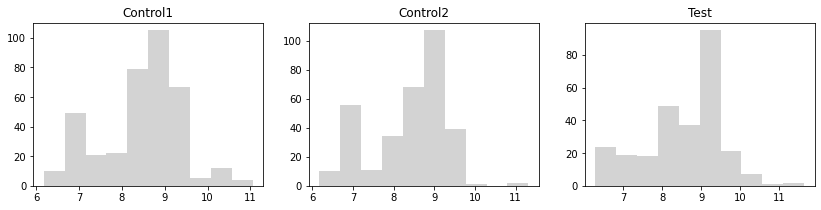

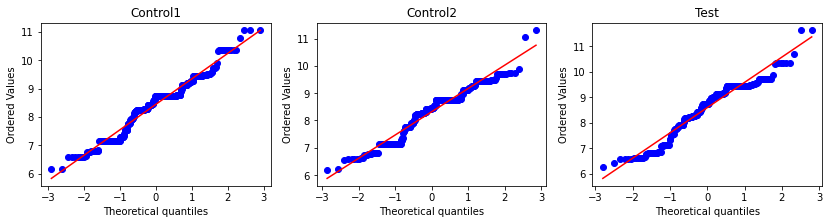

In [51]:
get3distributions(np.log(transactions_control_1_nnan0.revenue), 
                  np.log(transactions_control_2.revenue), 
                  np.log(transactions_test.revenue))

get3probs(np.log(transactions_control_1_nnan0.revenue), 
          np.log(transactions_control_2.revenue), 
          np.log(transactions_test.revenue))

Есть основания с большой уверенность полагать, что два других распределения для ARPU (особенно эта метрика, т.к. большинство значений равны нулю) и ARPPU будут иметь похожие свойства, плюс это было проверено и подверждено таким же образом, как и для среднего чека (распределение + QQ-график), и дабы не растягивать ноутбук, они не будут продемонтрированы.

В данной ситуации есть 2 пути анализа:
- Верить, что в нашем случае сработает ЗБЧ и ЦПТ и средние выборок из генеральной совокупности будут распределены нормально. Тогда мы можем воспользоваться параметрическими критериями, например, *t-тестом*, что, конечно, было бы более предпочтительно в виду большей мощности теста по сравнению с непараметрическими критериями и более конкретной интерпретации о равенстве/разнице средних
- Применить непараметрический критерий и быть уверенным в корректности подхода, однако с потерей в мощности и некоторой сложностью интерпретации результатов

**В нашем случае, т.к. нельзя точно сказать, большая ли выборка используется (чтобы работали ЗБЧ и ЦПТ) и корректно ли в целом применять параметрику, мной было принято решение - использовать непараметрический критерий**, а именно *критерий Краскела-Уоллиса* со следующими гипотезами: 
- *H0: каждая группа имеет одинаковое распределение величин в популяции*
- *H1: каждая группа не имеет одинакового распределения величин в популяции*

Перейдем уже непосредственно к анализу результатов эксперимента для наших трех метрик, для удобства сведем результаты в одну таблицу:

In [52]:
_, p_aov = stats.kruskal(transactions_merged.loc[transactions_merged.group == 'Control1'].revenue,
                         transactions_merged.loc[transactions_merged.group == 'Control2'].revenue,
                         transactions_merged.loc[transactions_merged.group == 'Test'].revenue)

_, p_arpu = stats.kruskal(users_merged.loc[users_merged.group == 'Control1'].total_revenue,
                          users_merged.loc[users_merged.group == 'Control2'].total_revenue,
                          users_merged.loc[users_merged.group == 'Test'].total_revenue)

_, p_arppu = stats.kruskal(users_merged.loc[(users_merged.group == 'Control1') & 
                                            (users_merged.cr == 1)].total_revenue,
                          users_merged.loc[(users_merged.group == 'Control2') & 
                                           (users_merged.cr == 1)].total_revenue,
                          users_merged.loc[(users_merged.group == 'Test') & 
                                           (users_merged.cr == 1)].total_revenue)

pd.DataFrame.from_dict({'AOV': p_aov, 'ARPU': p_arpu, 'ARPPU': p_arppu}, orient='index')

,0
AOV,0.000293
ARPU,0.031853
ARPPU,0.000024


**Результат применения теста говорит о том, что мы можем отклонить нулевую гипотезу для всех рассматриваемых метрик, следовательно, в наших группах есть различия.** Тогда применим *тест Данна с поправкой Холма*, чтобы узнать, между какими группами есть различия. Критерию соответствуют следующие гипотезы о стохастическом доминировании, которые совпадают с гипотезами *критерия Манна-Уитни*:
- *H0: для каждого попарного сравнения вероятность наблюдения случайно выбранного значения из первой группы больше, чем случайно выбранное значение из второй группы, равна половине*
- *H1: для каждого попарного сравнения вероятность наблюдения случайно выбранного значения из первой группы больше, чем случайно выбранное значение из второй группы, не равна половине*

Сравнивать будем все три экспериметальные группы для всех трех метрик, для этого немного трансформируем полученные результаты, чтобы вместо трех таблиц свести данные в одну таблицу. Построим также графики *pointplot*, чтобы понять характер различий:

In [53]:
aov0 = sp.posthoc_dunn(transactions_merged, val_col='revenue', group_col='group', p_adjust='holm')
aov0.index = aov0.index + ' AOV'

arpu0 = sp.posthoc_dunn(users_merged, val_col='total_revenue', group_col='group', p_adjust='holm')
arpu0.index = arpu0.index + ' ARPU'

arppu0 = sp.posthoc_dunn(users_merged.loc[users_merged.cr == 1], val_col='total_revenue', 
                         group_col='group', p_adjust='holm')
arppu0.index = arppu0.index + ' ARPPU'

pd.concat([aov0, arpu0, arppu0])

,Control1,Control2,Test
Control1 AOV,1.000000,0.114151,0.017388
Control2 AOV,0.114151,1.000000,0.000184
Test AOV,0.017388,0.000184,1.000000
Control1 ARPU,1.000000,0.949611,0.062808
Control2 ARPU,0.949611,1.000000,0.062808
Test ARPU,0.062808,0.062808,1.000000
Control1 ARPPU,1.000000,0.318844,0.000826
Control2 ARPPU,0.318844,1.000000,0.000027
Test ARPPU,0.000826,0.000027,1.000000


Text(0.5, 1.0, 'ARPPU')

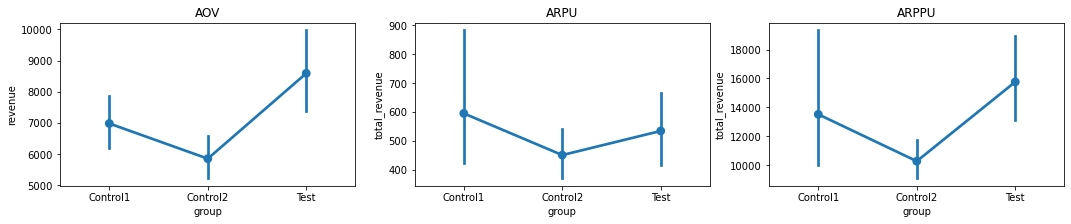

In [54]:
figure, axis = plt.subplots(1, 3, figsize=(18, 3))

sns.pointplot(data=transactions_merged, ax=axis[0], x="group", y="revenue")
axis[0].set_title("AOV")

sns.pointplot(data=users_merged, ax=axis[1], x="group", y="total_revenue")
axis[1].set_title("ARPU")

sns.pointplot(data=users_merged.loc[users_merged.cr == 1], ax=axis[2], x="group", y="total_revenue")
axis[2].set_title("ARPPU")

Видим из таблицы, что значимые различия получены только для AOV и ARPPU при чем в сравнениях тестовой группы с обеими контрольными, также графики дают понять, что для тестовой группы средние значения стали выше, из чего можем сделать вывод о том, что **метрики AOV и ARPPU значимо повысились**. 

### Сравнение экспериментальных групп в разрезах

#### Подготовка данных

Посмотрим на основные описательные статистики всех переменных, чтобы понять, на какие группы мы сможем разделить наших пользователей для последующего анализа:

In [55]:
users_merged.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,cr
count,1.291100e+04,12911.000000,12911.000000,169.000000,12911.000000,12911.000000,12911.000000,12911.000000,1254.0,539.0,12911.000000,12911.000000
mean,8.917516e+08,32.010534,315.479668,101.568047,0.955155,26.816048,38.566649,46.314538,1.0,1.0,526.876075,0.040586
std,1.490798e+06,10.224795,323.489680,706.264256,0.206973,9.447560,15.510433,282.912885,0.0,0.0,5524.874922,0.197336
min,8.910509e+08,16.000000,0.000000,1.000000,0.000000,13.000000,19.000000,0.000000,1.0,1.0,0.000000,0.000000
25%,8.913565e+08,25.000000,0.000000,6.000000,1.000000,19.000000,28.000000,1.000000,1.0,1.0,0.000000,0.000000
50%,8.917255e+08,30.000000,250.000000,10.000000,1.000000,25.000000,35.000000,6.000000,1.0,1.0,0.000000,0.000000
75%,8.920860e+08,38.000000,529.000000,28.000000,1.000000,32.000000,45.000000,21.000000,1.0,1.0,0.000000,0.000000
max,1.053059e+09,99.000000,1000.000000,8466.000000,1.000000,96.000000,102.000000,16157.000000,1.0,1.0,486330.000000,1.000000


Посмотрим на то, сколько в нашей аудитории представителей каждой страны. Видим, что около половины всех стран представлены всего 1-2 пользователем, поэтому определим страны с наибольшим количеством представителей - рассмотрим количество пользователей от 3 квартиля:

In [57]:
for_country = users_merged.groupby('country', as_index=False).agg({'uid':'count'})
for_country.uid.describe()

count      72.000000
mean      179.319444
std       577.803730
min         1.000000
25%         1.000000
50%         2.000000
75%        15.750000
max      4407.000000
Name: uid, dtype: float64

In [58]:
for_country.loc[for_country.uid > 15]

,country,uid
1,Argentina,1182
3,Australia,163
7,Belgium,290
11,Canada,405
12,Chile,845
19,France,1105
22,Germany,599
29,Israel,293
30,Italy,954
51,Portugal,291


Продолжая со странами, распределим все отобранные ранее страны по географическим регионам, а также создадим функцию для определения каждой страны к наиболее многочисленным регионам или к остальному миру. Также заведем несколько новых переменных для определения возрастной группы (на основе квартилей), группы по коэффициенту привлекательности (на основе квартилей), полу и типу продукта:

In [59]:
west_eur = ['Belgium', 'France', 'Germany', 'Italy', 'Portugal', 
            'Spain', 'Switzerland', 'United Kingdom (Great Britain)']
south_am = ['Argentina', 'Chile']
north_am = ['Canada', 'United States of America']
near_east = ['Israel', 'United Arab Emirates']


'''
input - (string) country
output - (string) geographic region according to previously determined lists of counties
'''
def set_country_group(country):
    if country in west_eur:
        return 'West_Europe'
    elif country in south_am:
        return 'South_America'
    elif country in north_am:
        return 'North_America'
    elif country in near_east:
        return 'Near_East'
    else:
        return 'Other_World'

    
users_merged['country_gr'] = users_merged.country.apply(set_country_group)

users_merged['age_group'] = pd.cut(users_merged.age, [0, 17, 25, 30, 40, 150], 
                                labels=["less18", "18_25", "26_30", "31_40", "40+"], 
                                right=True).astype(str)
users_merged['attr_gr'] = pd.cut(users_merged.attraction_coeff, [-1, 0, 250, 500, 1000], 
                                labels=["0", "1_250", "251_500", "501_1000"], 
                                right=True).astype(str)

users_merged['age_group_exp'] = users_merged['group'] + '/' + users_merged['age_group']
users_merged['attr_gr_exp'] = users_merged['group'] + '/' + users_merged['attr_gr']
users_merged['sex_gr_exp'] = users_merged['group'] + '/' + users_merged['gender'].astype(str)
users_merged['cntry_gr_exp'] = users_merged['group'] + '/' + users_merged['country_gr']
users_merged['sex_age'] = users_merged['group'] + '/' + users_merged['gender'].astype(str) + '/' +\
                                users_merged['age_group']

merged_all = transactions_merged[['revenue', 'uid', 'product_type']].merge(users_merged, how='inner', on='uid')
merged_all['prod_gr_exp'] = merged_all['group'] + '/' + merged_all['product_type']

#### Разрез (экспериментальная группа/тип продукта)

Проанализируем результаты по экспериментальной группе и типу продукта, сравнить мы сможем только AOV и ARPPU. Чтобы более удобно было оценивать результаты, замаскируем сравнения группы с самой собой и сравнения разных второстепенных групп (в данном случае это тип продукта) и подсветим ячейки с уровнем значимости, меньшим 0.05 . Также построим pointplot-графики для групп, где обноружены значимые изменения, чтобы понять характер изменений:

In [60]:
prod_arppu = merged_all.groupby(['uid', 'prod_gr_exp'], as_index=False).agg({'revenue':'sum'})

prod_comp_aov = sp.posthoc_dunn(merged_all, val_col='revenue', group_col='prod_gr_exp', p_adjust='holm')
prod_comp_aov = prod_comp_aov.mask(~np.equal.outer(prod_comp_aov.index.str.split('/').str[-1], 
                                                   prod_comp_aov.columns.str.split('/').str[-1]))
prod_comp_aov = prod_comp_aov.mask(np.equal.outer(prod_comp_aov.index, prod_comp_aov.columns))
prod_comp_aov.index = prod_comp_aov.index + ' AOV'

prod_comp_arppu = sp.posthoc_dunn(prod_arppu, val_col='revenue', group_col='prod_gr_exp', p_adjust='holm')
prod_comp_arppu = prod_comp_arppu.mask(~np.equal.outer(prod_comp_arppu.index.str.split('/').str[-1], 
                                                       prod_comp_arppu.columns.str.split('/').str[-1]))
prod_comp_arppu = prod_comp_arppu.mask(np.equal.outer(prod_comp_arppu.index, prod_comp_arppu.columns))
prod_comp_arppu.index = prod_comp_arppu.index + ' ARPPU'

pd.concat([prod_comp_aov.loc[prod_comp_aov.index.str.startswith('Test'), 
                             prod_comp_aov.columns.str.startswith('Control').tolist()],
           prod_comp_arppu.loc[prod_comp_arppu.index.str.startswith('Test'), 
                               prod_comp_arppu.columns.str.startswith('Control').tolist()]])\
    .style.apply(lambda x: ["background: green" if v < 0.05 else "" for v in x], axis = 1)

,Control1/coins,Control1/other_type,Control1/premium_no_trial,Control1/trial_premium,Control2/coins,Control2/other_type,Control2/premium_no_trial,Control2/trial_premium
Test/coins AOV,1.000000,nan,nan,nan,1.000000,nan,nan,nan
Test/other_type AOV,nan,1.000000,nan,nan,nan,1.000000,nan,nan
Test/premium_no_trial AOV,nan,nan,0.036147,nan,nan,nan,0.149119,nan
Test/trial_premium AOV,nan,nan,nan,1.000000,nan,nan,nan,1.000000
Test/coins ARPPU,1.000000,nan,nan,nan,1.000000,nan,nan,nan
Test/other_type ARPPU,nan,1.000000,nan,nan,nan,1.000000,nan,nan
Test/premium_no_trial ARPPU,nan,nan,0.003859,nan,nan,nan,0.008422,nan
Test/trial_premium ARPPU,nan,nan,nan,1.000000,nan,nan,nan,1.000000


Text(0.5, 0, 'Experiment/Product Type group')

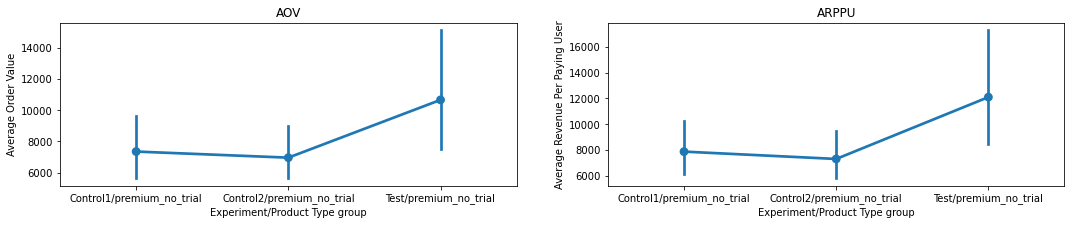

In [61]:
figure, axis = plt.subplots(1, 2, figsize=(18, 3))

sns.pointplot(x="prod_gr_exp", y="revenue", data=merged_all.loc[merged_all.product_type == 'premium_no_trial'],
              ax=axis[0])
axis[0].set_title("AOV")
axis[0].set_ylabel("Average Order Value")
axis[0].set_xlabel("Experiment/Product Type group")

sns.pointplot(data=prod_arppu.loc[prod_arppu.prod_gr_exp.str.contains('premium_no_trial')]\
                      .sort_values('prod_gr_exp'),
              ax=axis[1], x="prod_gr_exp", y="revenue")
axis[1].set_title("ARPPU")
axis[1].set_ylabel("Average Revenue Per Paying User")
axis[1].set_xlabel("Experiment/Product Type group")

По результатам сравнений получаем значимые различия среднего чека по премиум-подписке только в TestvsControl1, в то же время наблюдаем значимые различия ARPPU в сравнении теста с обоими контролями, из этого факта и графиков делаем вывод, что AOV и ARPPU повысились только для премиум-подписки.


Далее посмотрим на некоторые разрезы уже только внутри пользователей с премиум-подпиской, немного подготовим данные для таких сравнений:

In [62]:
trans = transactions_merged.loc[transactions_merged.product_type == 'premium_no_trial']\
                            .groupby('uid', as_index=False)\
                            .agg({'revenue':'sum'})

for_arp = users_merged.merge(trans, how='left', on='uid')
for_arp['is_prem'] = for_arp.revenue.apply(lambda x: 1 if x > 0 else 0)
for_arp = for_arp.loc[(for_arp.cr == 0) | (for_arp.is_prem == 1)]
for_arp.revenue.fillna(0, inplace=True)

for_aov = merged_all.loc[merged_all.product_type == 'premium_no_trial']

Для удобства и аккуратности последующего повествования, автоматизируем создание результирующей таблицы сравнений. Как и ранее будем маскировать сравнения групп с самими собой и сравнения не связанных групп (например, разных возрастных групп), а также подсветим ячейки с уровнем значимости меньшим 0.05, чтобы удобно было искать такие значения в больших таблицах. Так как, к сожалению, подсветка отображается только при запуске кода и не сохраняется в ноутбуке, ниже представлен пример того, как выглядит полученная таблица: 

In [63]:
'''
input: (3 DataFrames + string) - pandas DataFrames which represents main metrics and group to compare, 
                                 precisely in the next order AOV, ARPU, ARPPU, group to compare
output: (DataFrame) - result table of comparisons by comparing groups
'''
def get_dunn_result_table(aov, arpu, arppu, compare_group):
    
    aov1 = sp.posthoc_dunn(aov, val_col='revenue', group_col=compare_group, p_adjust='holm')
    aov1 = aov1.mask(~np.equal.outer(aov1.index.str.split('/').str[-1], aov1.columns.str.split('/').str[-1]))
    aov1 = aov1.mask(np.equal.outer(aov1.index, aov1.columns))
    aov1.index = aov1.index + ' AOV'

    arpu1 = sp.posthoc_dunn(arpu, val_col='revenue', group_col=compare_group, p_adjust='holm')
    arpu1 = arpu1.mask(~np.equal.outer(arpu1.index.str.split('/').str[-1], arpu1.columns.str.split('/').str[-1]))
    arpu1 = arpu1.mask(np.equal.outer(arpu1.index, arpu1.columns))
    arpu1.index = arpu1.index + ' ARPU'

    arppu1 = sp.posthoc_dunn(arppu, val_col='revenue', group_col=compare_group, p_adjust='holm')
    arppu1 = arppu1.mask(~np.equal.outer(arppu1.index.str.split('/').str[-1], 
                                         arppu1.columns.str.split('/').str[-1]))
    arppu1 = arppu1.mask(np.equal.outer(arppu1.index, arppu1.columns))
    arppu1.index = arppu1.index + ' ARPPU'

    res1 = pd.concat([aov1.loc[aov1.index.str.startswith('Test'), aov1.columns.str.startswith('Control').tolist()],
               arpu1.loc[arpu1.index.str.startswith('Test'), arpu1.columns.str.startswith('Control').tolist()],
               arppu1.loc[arppu1.index.str.startswith('Test'), arppu1.columns.str.startswith('Control').tolist()]])

    return res1.style.apply(lambda x: ["background: green" if v < 0.05 else "" for v in x], axis = 1)

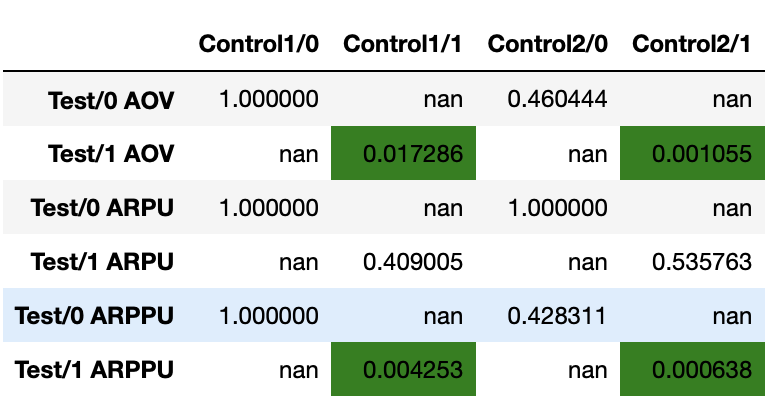

#### Разрез (премиум-подписка + экспериментальная группа/возрастная группа)

In [64]:
res1 = get_dunn_result_table(for_aov, for_arp, for_arp.loc[for_arp.cr == 1], 'age_group_exp')
res1

,Control1/18_25,Control1/26_30,Control1/31_40,Control1/40+,Control1/less18,Control2/18_25,Control2/26_30,Control2/31_40,Control2/40+,Control2/less18
Test/18_25 AOV,0.132893,nan,nan,nan,nan,0.431955,nan,nan,nan,nan
Test/26_30 AOV,nan,0.003000,nan,nan,nan,nan,0.001650,nan,nan,nan
Test/31_40 AOV,nan,nan,1.000000,nan,nan,nan,nan,1.000000,nan,nan
Test/40+ AOV,nan,nan,nan,1.000000,nan,nan,nan,nan,1.000000,nan
Test/less18 AOV,nan,nan,nan,nan,1.000000,nan,nan,nan,nan,1.000000
Test/18_25 ARPU,1.000000,nan,nan,nan,nan,1.000000,nan,nan,nan,nan
Test/26_30 ARPU,nan,0.394247,nan,nan,nan,nan,0.002991,nan,nan,nan
Test/31_40 ARPU,nan,nan,1.000000,nan,nan,nan,nan,1.000000,nan,nan
Test/40+ ARPU,nan,nan,nan,1.000000,nan,nan,nan,nan,1.000000,nan
Test/less18 ARPU,nan,nan,nan,nan,1.000000,nan,nan,nan,nan,1.000000


Text(0.5, 0, 'Experiment/Age group')

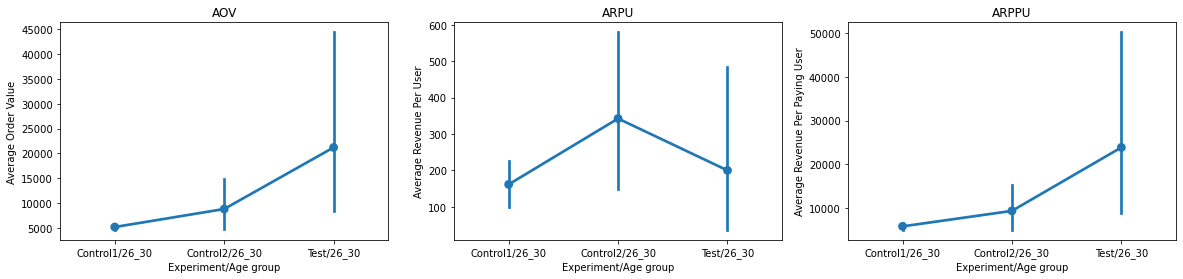

In [66]:
figure, axis = plt.subplots(1, 3, figsize=(20, 4))

sns.pointplot(x="age_group_exp", y="revenue", data=for_aov.loc[for_aov.age_group == '26_30'], 
              ax=axis[0])
axis[0].set_title("AOV")
axis[0].set_ylabel("Average Order Value")
axis[0].set_xlabel("Experiment/Age group")

sns.pointplot(x="age_group_exp", y="revenue", data=for_arp.loc[(for_arp.age_group == '26_30')], 
              ax=axis[1])
axis[1].set_title("ARPU")
axis[1].set_ylabel("Average Revenue Per User")
axis[1].set_xlabel("Experiment/Age group")

sns.pointplot(x="age_group_exp", y="revenue", data=for_arp.loc[(for_arp.cr == 1) & 
                                                               (for_arp.age_group == '26_30')], 
              ax=axis[2])
axis[2].set_title("ARPPU")
axis[2].set_ylabel("Average Revenue Per Paying User")
axis[2].set_xlabel("Experiment/Age group")

По результатам сравнений значимые различия получены для всех трех метрик для возрастной группы от 26 до 30, также графикам понимаем, что для тестовой группы средние значения AOV и ARPPU стали выше. Сложно что-то сказать о характере изменении ARPU, однако точно можно сказать, что значимого роста метрики не наблюдается, что согласуется с ранее полученными данными о значимом падении конверсии в этой возрастной группе. Видим также, что в тестовой группе значительно возрасла дисперсия для AOV и ARPPU.

#### Разрез (премиум-подписка + экспериментальная группа/группа по коэффициенту привлекательности)

In [67]:
res2 = get_dunn_result_table(for_aov, for_arp, for_arp.loc[for_arp.cr == 1], 'attr_gr_exp')
res2

,Control1/0,Control1/1_250,Control1/251_500,Control1/501_1000,Control2/0,Control2/1_250,Control2/251_500,Control2/501_1000
Test/0 AOV,1.000000,nan,nan,nan,1.000000,nan,nan,nan
Test/1_250 AOV,nan,0.034310,nan,nan,nan,0.393742,nan,nan
Test/251_500 AOV,nan,nan,0.160893,nan,nan,nan,0.163115,nan
Test/501_1000 AOV,nan,nan,nan,0.983904,nan,nan,nan,0.982561
Test/0 ARPU,1.000000,nan,nan,nan,1.000000,nan,nan,nan
Test/1_250 ARPU,nan,1.000000,nan,nan,nan,0.778633,nan,nan
Test/251_500 ARPU,nan,nan,0.988407,nan,nan,nan,0.553044,nan
Test/501_1000 ARPU,nan,nan,nan,1.000000,nan,nan,nan,1.000000
Test/0 ARPPU,1.000000,nan,nan,nan,1.000000,nan,nan,nan
Test/1_250 ARPPU,nan,0.197477,nan,nan,nan,0.431437,nan,nan


Text(0.5, 0, 'Experiment/Gender group')

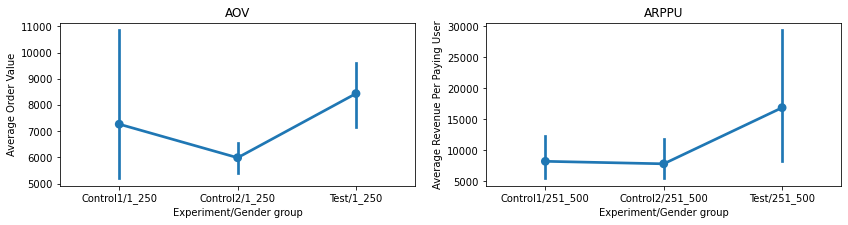

In [68]:
figure, axis = plt.subplots(1, 2, figsize=(14, 3))

sns.pointplot(x="attr_gr_exp", y="revenue", data=for_aov.loc[for_aov.attr_gr == '1_250'], ax=axis[0])
axis[0].set_title("AOV")
axis[0].set_ylabel("Average Order Value")
axis[0].set_xlabel("Experiment/Gender group")

sns.pointplot(data=for_arp.loc[(for_arp.cr == 1) &(for_arp.attr_gr == '251_500')], 
              x="attr_gr_exp", y="revenue", ax=axis[1])
axis[1].set_title("ARPPU")
axis[1].set_ylabel("Average Revenue Per Paying User")
axis[1].set_xlabel("Experiment/Gender group")

По результатам сравнений значимые различия получены для AOV c коэффициентом привлекательности от 1 до 250, но только для сравнения теста с контролем 2, однако видим очень высокую диспесию в первом контроле, можно вспомнить, что в первом контроле есть один пользователь с очень большим чеком, который завышает средний чек.

Также различия были найдены для ARPPU c коэффициентом привлекательности от 251 до 500, по графику видим, что в тестовом варианте метрика выросла.

#### Разрез (премиум-подписка + экспериментальная группа/пол)

In [69]:
res3 = get_dunn_result_table(for_aov, for_arp, for_arp.loc[for_arp.cr == 1], 'sex_gr_exp')
res3

,Control1/1,Control2/0,Control2/1,Control1/0
Test/1 AOV,0.000000,nan,0.000018,nan
Test/0 ARPU,nan,0.694806,nan,1.000000
Test/1 ARPU,0.285995,nan,0.285995,nan
Test/1 ARPPU,0.000000,nan,0.000004,nan


Text(0.5, 0, 'Experiment/Gender group')

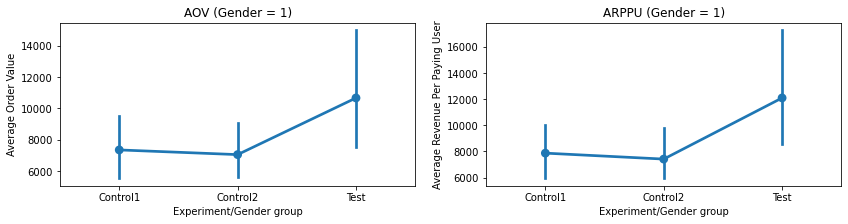

In [70]:
figure, axis = plt.subplots(1, 2, figsize=(14, 3))

sns.pointplot(x="group", y="revenue", data=for_aov.loc[for_aov.gender == 1], ax=axis[0])
axis[0].set_title("AOV (Gender = 1)")
axis[0].set_ylabel("Average Order Value")
axis[0].set_xlabel("Experiment/Gender group")

sns.pointplot(data=for_arp.loc[(for_arp.cr == 1) & (for_arp.gender == 1)], 
              x="group", y="revenue", ax=axis[1])
axis[1].set_title("ARPPU (Gender = 1)")
axis[1].set_ylabel("Average Revenue Per Paying User")
axis[1].set_xlabel("Experiment/Gender group")

Сравнения показывают значимые различия для AOV и ARPPU, по характеру графика также видим, что метрики увеличились в тестовой группе, однако также с более высокой дисперсией значений.

#### Разрез (премиум-подписка + экспериментальная группа/группа стран)

In [71]:
res5 = get_dunn_result_table(for_aov, for_arp, for_arp.loc[for_arp.cr == 1], 'cntry_gr_exp')
res5

,Control1/Near_East,Control1/North_America,Control1/Other_World,Control1/South_America,Control1/West_Europe,Control2/Near_East,Control2/North_America,Control2/Other_World,Control2/South_America,Control2/West_Europe
Test/Near_East AOV,0.078832,nan,nan,nan,nan,1.000000,nan,nan,nan,nan
Test/North_America AOV,nan,0.075798,nan,nan,nan,nan,0.075799,nan,nan,nan
Test/Other_World AOV,nan,nan,1.000000,nan,nan,nan,nan,1.000000,nan,nan
Test/South_America AOV,nan,nan,nan,1.000000,nan,nan,nan,nan,1.000000,nan
Test/West_Europe AOV,nan,nan,nan,nan,1.000000,nan,nan,nan,nan,1.000000
Test/Near_East ARPU,1.000000,nan,nan,nan,nan,1.000000,nan,nan,nan,nan
Test/North_America ARPU,nan,1.000000,nan,nan,nan,nan,1.000000,nan,nan,nan
Test/Other_World ARPU,nan,nan,1.000000,nan,nan,nan,nan,1.000000,nan,nan
Test/South_America ARPU,nan,nan,nan,1.000000,nan,nan,nan,nan,1.000000,nan
Test/West_Europe ARPU,nan,nan,nan,nan,1.000000,nan,nan,nan,nan,0.467906


Text(0.5, 0, 'Experiment/Gender group')

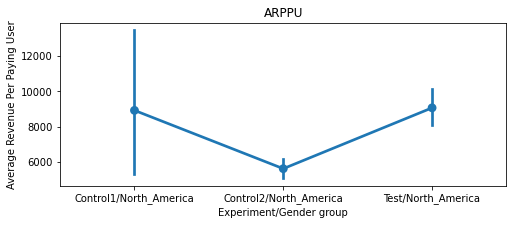

In [72]:
plt.figure(figsize=(8, 3))
sns.pointplot(data=for_arp.loc[(for_arp.cr == 1) & (for_arp.country_gr == 'North_America')], 
              x="cntry_gr_exp", y="revenue")
plt.title("ARPPU")
plt.ylabel("Average Revenue Per Paying User")
plt.xlabel("Experiment/Gender group")

Получены различия в ARPPU, по которым видим повышение метрики, однако аналогично с одним из предыдущих разрезов, для первого контроля есть завышение среднего за счет одного пользователя с очень большим общим чеком.

In [73]:
res6 = get_dunn_result_table(for_aov, for_arp, for_arp.loc[for_arp.cr == 1], 'sex_age')
res6

,Control1/1/18_25,Control1/1/26_30,Control1/1/31_40,Control1/1/40+,Control1/1/less18,Control2/0/26_30,Control2/0/31_40,Control2/1/18_25,Control2/1/26_30,Control2/1/31_40,Control2/1/40+,Control2/1/less18,Control1/0/18_25,Control1/0/26_30,Control1/0/31_40,Control1/0/40+,Control1/0/less18,Control2/0/18_25,Control2/0/40+,Control2/0/less18
Test/1/18_25 AOV,0.177191,nan,nan,nan,nan,nan,nan,0.589030,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Test/1/26_30 AOV,nan,0.003894,nan,nan,nan,1.000000,nan,nan,0.003169,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Test/1/31_40 AOV,nan,nan,1.000000,nan,nan,nan,1.000000,nan,nan,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Test/1/40+ AOV,nan,nan,nan,1.000000,nan,nan,nan,nan,nan,nan,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan
Test/1/less18 AOV,nan,nan,nan,nan,1.000000,nan,nan,nan,nan,nan,nan,1.000000,nan,nan,nan,nan,nan,nan,nan,nan
Test/0/18_25 ARPU,1.000000,nan,nan,nan,nan,nan,nan,1.000000,nan,nan,nan,nan,1.000000,nan,nan,nan,nan,1.000000,nan,nan
Test/0/26_30 ARPU,nan,1.000000,nan,nan,nan,1.000000,nan,nan,1.000000,nan,nan,nan,nan,1.000000,nan,nan,nan,nan,nan,nan
Test/0/31_40 ARPU,nan,nan,1.000000,nan,nan,nan,1.000000,nan,nan,1.000000,nan,nan,nan,nan,1.000000,nan,nan,nan,nan,nan
Test/0/40+ ARPU,nan,nan,nan,1.000000,nan,nan,nan,nan,nan,nan,1.000000,nan,nan,nan,nan,1.000000,nan,nan,1.000000,nan
Test/0/less18 ARPU,nan,nan,nan,nan,1.000000,nan,nan,nan,nan,nan,nan,1.000000,nan,nan,nan,nan,1.000000,nan,nan,1.000000


Следующее сравнение является неким сборным двух из предыдущих сравнений и подтверждает предыдущие наблюдения, что различия зафиксированы только для представителей гендера 1 в возрасте от 26 до 30.

## *Метрики в динамике*

### Средний чек (AOV) и доход на платящего пользователя (ARPPU)

Было бы полезно посмотреть на исследуемые метрики в динамике по всем экспериментальным группам, а также накопленную сумму по этим показателям, рассмотрим их помесячно. Немного подготовим данные и обернем в функцию отрисовку графиков. Так как функция без агрументов и предназначена только для большей аккуратности, описана она не будет:

In [74]:
monthly1 = transactions_merged[['group', 'paid_month', 'revenue', 'uid', 'paid_at']]\
                            .groupby(['group', 'paid_month'], as_index=False)\
                            .agg({'revenue':'sum', 'uid':pd.Series.nunique, 'paid_at':'count'})

monthly1['aov'] = monthly1.revenue/monthly1.paid_at
monthly1.loc[monthly1.group == 'Control1', 'cumul_aov'] = np.cumsum(monthly1.loc[monthly1.group == 'Control1'].aov)
monthly1.loc[monthly1.group == 'Control2', 'cumul_aov'] = np.cumsum(monthly1.loc[monthly1.group == 'Control2'].aov)
monthly1.loc[monthly1.group == 'Test', 'cumul_aov'] = np.cumsum(monthly1.loc[monthly1.group == 'Test'].aov)

monthly1['arppu'] = monthly1.revenue/monthly1.uid
monthly1.loc[monthly1.group == 'Control1', 'cumul_arppu'] = np.cumsum(monthly1.loc[monthly1.group == 'Control1']
                                                                      .arppu)
monthly1.loc[monthly1.group == 'Control2', 'cumul_arppu'] = np.cumsum(monthly1.loc[monthly1.group == 'Control2']
                                                                      .arppu)
monthly1.loc[monthly1.group == 'Test', 'cumul_arppu'] = np.cumsum(monthly1.loc[monthly1.group == 'Test'].arppu)


def get_prefinal_plot():
    figure, axis = plt.subplots(2, 2, figsize=(20, 8))

    
    axis[0, 0].plot(monthly1.loc[monthly1.group == 'Control1'].paid_month, 
             monthly1.loc[monthly1.group == 'Control1'].aov, color = 'lightgrey')
    axis[0, 0].plot(monthly1.loc[monthly1.group == 'Control2'].paid_month, 
             monthly1.loc[monthly1.group == 'Control2'].aov, color = 'grey')
    axis[0, 0].plot(monthly1.loc[monthly1.group == 'Test'].paid_month, 
             monthly1.loc[monthly1.group == 'Test'].aov, color = 'red')
    axis[0, 0].set_title('Monthly AOV')

    axis[1, 0].plot(monthly1.loc[monthly1.group == 'Control1'].paid_month, 
             monthly1.loc[monthly1.group == 'Control1'].cumul_aov, color = 'lightgrey', label='Control1')
    axis[1, 0].plot(monthly1.loc[monthly1.group == 'Control2'].paid_month, 
             monthly1.loc[monthly1.group == 'Control2'].cumul_aov, color = 'grey', label='Control2')
    axis[1, 0].plot(monthly1.loc[monthly1.group == 'Test'].paid_month, 
             monthly1.loc[monthly1.group == 'Test'].cumul_aov, color = 'red', label='Test')
    axis[1, 0].set_title('Monthly cumulative AOV')
    
    
    axis[0, 1].plot(monthly1.loc[monthly1.group == 'Control1'].paid_month, 
             monthly1.loc[monthly1.group == 'Control1'].arppu, color = 'lightgrey')
    axis[0, 1].plot(monthly1.loc[monthly1.group == 'Control2'].paid_month, 
             monthly1.loc[monthly1.group == 'Control2'].arppu, color = 'grey')
    axis[0, 1].plot(monthly1.loc[monthly1.group == 'Test'].paid_month, 
             monthly1.loc[monthly1.group == 'Test'].arppu, color = 'red')
    axis[0, 1].set_title('Monthly ARPPU')

    axis[1, 1].plot(monthly1.loc[monthly1.group == 'Control1'].paid_month, 
             monthly1.loc[monthly1.group == 'Control1'].cumul_arppu, color = 'lightgrey')
    axis[1, 1].plot(monthly1.loc[monthly1.group == 'Control2'].paid_month, 
             monthly1.loc[monthly1.group == 'Control2'].cumul_arppu, color = 'grey')
    axis[1, 1].plot(monthly1.loc[monthly1.group == 'Test'].paid_month, 
             monthly1.loc[monthly1.group == 'Test'].cumul_arppu, color = 'red')
    axis[1, 1].set_title('Monthly cumulative ARPPU')

    figure.legend(loc='upper right')

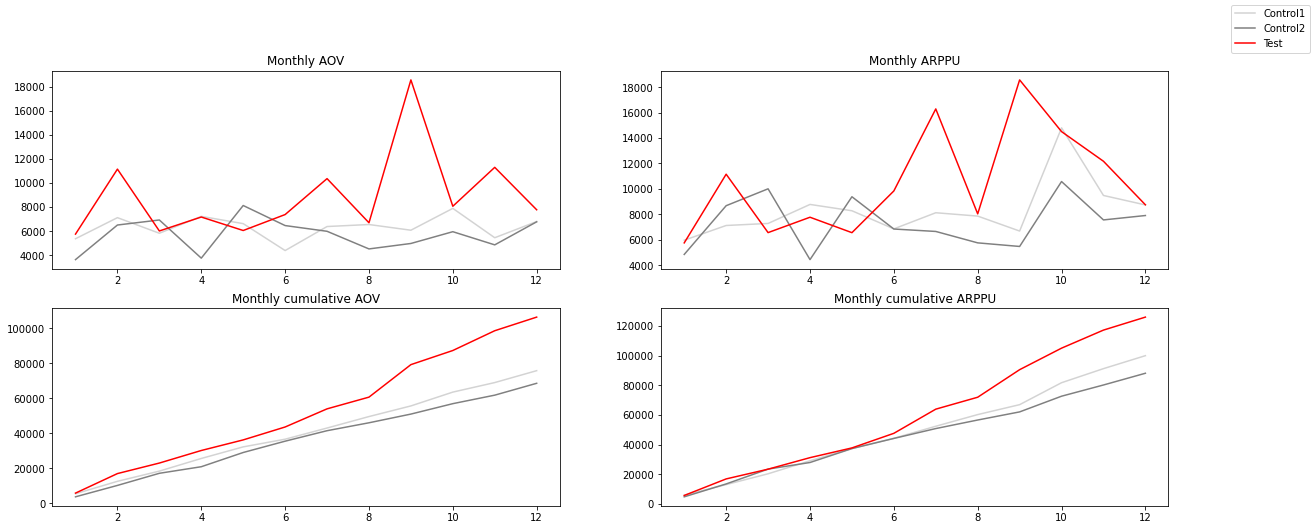

In [75]:
get_prefinal_plot()

### Выручка

Также, я считаю, достаточно показательным может быть изменение динамики выручки по нашим экспериментальным группам.
В конце концов это и есть цель любого бизнеса. Видим, что в целом общая выручка по тестовой группе где-то между обеими контрольными:

Text(0.5, 1.0, 'Cumulative revenue')

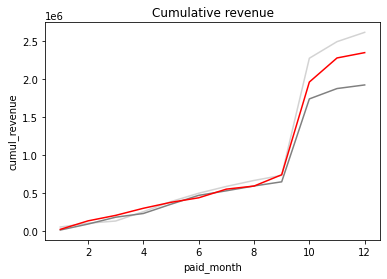

In [76]:
rev = transactions_merged.groupby(['group','paid_month'], as_index=False).agg({'revenue':'sum'})

rev.loc[rev.group == 'Control1', 'cumul_revenue'] = np.cumsum(rev.loc[rev.group == 'Control1'].revenue)
rev.loc[rev.group == 'Control2', 'cumul_revenue'] = np.cumsum(rev.loc[rev.group == 'Control2'].revenue)
rev.loc[rev.group == 'Test', 'cumul_revenue'] = np.cumsum(rev.loc[rev.group == 'Test'].revenue)

sns.lineplot(data=rev.loc[rev.group == 'Control1'], x="paid_month", y="cumul_revenue", color='lightgrey')
sns.lineplot(data=rev.loc[rev.group == 'Control2'], x="paid_month", y="cumul_revenue", color='grey')
sns.lineplot(data=rev.loc[rev.group == 'Test'], x="paid_month", y="cumul_revenue", color='red')
plt.title('Cumulative revenue')

Однако не забываем про нашего одного пользователя с огромным чеком и просто ради интереса посмотрим на выручку без его учета. Видим, что теперь выручка по тестовой группе выше контрольных:

Text(0.5, 1.0, 'Cumulative revenue')

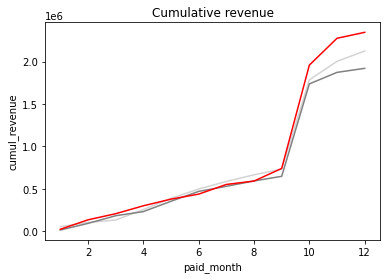

In [77]:
rev1 = transactions_merged.loc[transactions_merged.uid != BEST_USER]\
                         .groupby(['group','paid_month'], as_index=False)\
                         .agg({'revenue':'sum'})

rev1.loc[rev1.group == 'Control1', 'cumul_revenue'] = np.cumsum(rev1.loc[rev1.group == 'Control1'].revenue)
rev1.loc[rev1.group == 'Control2', 'cumul_revenue'] = np.cumsum(rev1.loc[rev1.group == 'Control2'].revenue)
rev1.loc[rev1.group == 'Test', 'cumul_revenue'] = np.cumsum(rev1.loc[rev1.group == 'Test'].revenue)

sns.lineplot(data=rev1.loc[rev1.group == 'Control1'], x="paid_month", y="cumul_revenue", color='lightgrey')
sns.lineplot(data=rev1.loc[rev1.group == 'Control2'], x="paid_month", y="cumul_revenue", color='grey')
sns.lineplot(data=rev1.loc[rev1.group == 'Test'], x="paid_month", y="cumul_revenue", color='red')
plt.title('Cumulative revenue')

# Общий вывод по результатам эксперимента



Есть много вопросов к качеству данных (особенно для первой контрольной группы), стоит проверить их корректность по моментам, обозначенным ранее. Также стоит проверить, закономерная ли история пользователей с огромным чеком, т.к. это значение в значительной степени искажает статистические показатели, утягивая их за собой в большую сторону, примеры чего мы неоднократно наблюдали в ходе анализа.

По результатам эксперимента можно с большой уверенностью сказать, что **от изменения ценовой политики премиум-подписки конверсия упала в среднем на 33.4%, средний чек увеличился на 49.1%**. 

Изменение наиболее сильно повлияло на пользователей в возрасте от 26 до 30 лет, **конверсия в этой возрастной группе упала на 71.9%, средний чек увеличился на 203.6%** .

Я все же предполагаю, что цены были увеличены и, соответственно, рост денежных метрик закономерен. Если после проверки данных окажется, что пользователь с очень большим чеком реален, то общая выручка за все время эксперимента не возрасла, т.е. падение конверсии больше сказалось на выручке. Прирост по денежным метрикам может в краткосрочной перспективе принести прибыль, учитывая, что подписка автоматически продлевается, т.е. теоретически пользователь мог не заметить изменения цены, а когда заметит, может отказаться. В долгосрочной же перспективе при общем падении конверсии это может привести к очень большим потерям аудитории, которую сложно набрать и еще сложнее потом вернуть в продукт. Плюс к этому конверсия наиболее значимо упала в одной из, я так предполагаю, самых главных групп, 26-30 лет - это относительно молодые, платежеспособные люди (в сравнении с группой 18-25, куда попадает большинство студентов).

**Моя оценка - эксперимент неудачный, его не стоит распространять на всех пользователей.**